# **1. Perkenalan**
---
### **Final Project: Loyalify - Prediksi Customer Churn**

### **CLUSTERING NOTEBOOK UNTUK CUSTOMER SEGMENTATION**

**Group 2:** 
1. Azhar Muhammad
2. Nathanael August Zefanya
3. Pradita Ajeng Wiguna

Proyek ini bertujuan untuk membangun sistem peringatan dini proaktif menggunakan machine learning untuk mengidentifikasi pelanggan telekomunikasi yang berisiko tinggi untuk churn (berhenti berlangganan).

Notebook ini ditulis oleh Pradita Ajeng Wiguna


# **2. Import Libraries**
---
Pada tahap awal ini, saya mengimpor semua library yang diperlukan untuk proses pengolahan data, visualisasi, modeling, dan evaluasi model. Semua library saya kumpulkan dalam satu cell agar notebook lebih rapi.

In [28]:
# Import libraries
import pandas as pd
import numpy as np

# Libraries untuk visualisasi
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import silhouette_score,silhouette_samples

# Model
from sklearn.cluster import KMeans

# Menyimpan model
import pickle

# Mengabaikan warning
import warnings
warnings.filterwarnings('ignore')

# **3. Data Loading**
---

In [16]:
# Load Dataset
# Dataset hasil preprocessing sebelumnya
# (sudah drop kolom yang tidak dipakai, sudah handle outlier, dll)
df = pd.read_csv('customer_data_for_clustering_clean.csv')
df.head()

,Unnamed: 0,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,distinct_called_numbers,age_group,tariff_plan,status,customer_value
0,1872,0,36.0,0,650,47,16.0,3,1,2,95.88
1,1635,0,35.0,0,3528,82,30.0,3,1,1,252.40
2,2367,0,46.0,0,1275,30,16.0,3,1,2,192.20
3,2817,0,40.0,0,825,19,7.0,3,1,2,77.76
4,2222,1,33.0,0,1200,50,17.0,3,1,2,122.00


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2280 non-null   int64  
 1   complains                2280 non-null   int64  
 2   subscription_length      2280 non-null   float64
 3   charge_amount            2280 non-null   int64  
 4   seconds_of_use           2280 non-null   int64  
 5   frequency_of_use         2280 non-null   int64  
 6   distinct_called_numbers  2280 non-null   float64
 7   age_group                2280 non-null   int64  
 8   tariff_plan              2280 non-null   int64  
 9   status                   2280 non-null   int64  
 10  customer_value           2280 non-null   float64
dtypes: float64(3), int64(8)
memory usage: 196.1 KB


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2280.0,1519.897368,904.098947,0.0,696.7500,1527.500,2336.25000,3131.000000
complains,2280.0,0.079825,0.271081,0.0,0.0000,0.000,0.00000,1.000000
subscription_length,2280.0,32.782237,7.886776,15.5,29.0000,35.000,38.00000,46.000000
charge_amount,2280.0,0.963158,1.538294,0.0,0.0000,0.000,1.00000,10.000000
seconds_of_use,2280.0,4478.575877,4026.274821,0.0,1448.2500,3067.500,6519.75000,14127.000000
frequency_of_use,2280.0,69.405263,54.426845,0.0,28.0000,55.000,96.00000,198.000000
distinct_called_numbers,2280.0,23.678728,16.496505,0.0,11.0000,21.000,34.00000,68.500000
age_group,2280.0,2.837281,0.903076,1.0,2.0000,3.000,3.00000,5.000000
tariff_plan,2280.0,1.078070,0.268341,1.0,1.0000,1.000,1.00000,2.000000
status,2280.0,1.239474,0.426856,1.0,1.0000,1.000,1.00000,2.000000


In [33]:
df.columns

Index(['Unnamed: 0', 'complains', 'subscription_length', 'charge_amount',
       'seconds_of_use', 'frequency_of_use', 'distinct_called_numbers',
       'age_group', 'tariff_plan', 'status', 'customer_value'],
      dtype='object')

# **4. Feature Engineering**
---

#### **Preprocessing Pipeline**

In [34]:
# Drop kolom unnamaed
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [35]:
# Kolom numerik (continuous)
numerical_cols_selected = ['subscription_length', 'seconds_of_use', 'frequency_of_use', 
                  'distinct_called_numbers', 'customer_value']

# Kolom ordinal (karena ada urutannya)
ordinal_cols_selected = ['charge_amount', 'age_group']

# Kolom kategorikal nominal (tanpa urutan)
categorical_cols_selected = ['complains', 'tariff_plan', 'status']

print(f"Kolom Numerik: {numerical_cols_selected}")
print(f"Kolom Ordinal: {ordinal_cols_selected}")
print(f"Kolom Kategorikal: {categorical_cols_selected}")

Kolom Numerik: ['subscription_length', 'seconds_of_use', 'frequency_of_use', 'distinct_called_numbers', 'customer_value']
Kolom Ordinal: ['charge_amount', 'age_group']
Kolom Kategorikal: ['complains', 'tariff_plan', 'status']


In [36]:
preprocessor= ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_cols_selected),
        ('ord_encode', OrdinalEncoder( handle_unknown='use_encoded_value', 
                                      unknown_value=-1), # Mengatasi unknown di test
                                      ordinal_cols_selected),
        ('cat_ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), 
                          categorical_cols_selected)
    ])

In [45]:
# Transformasi Fitur
# Fit dan transform data
df_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(df),             # Melakukan scaling pada df_selected
    columns=df.columns,                   # Memberikan nama kolom yang sesuai
    index=df.index                        # Menjaga indeks yang sama dengan df_selected
)
df_preprocessed.head()

,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,distinct_called_numbers,age_group,tariff_plan,status,customer_value
0,0.408084,-0.951106,-0.411749,-0.465578,-0.751770,0.0,2.0,0.0,0.0,1.0
1,0.281262,-0.236145,0.231457,0.383273,-0.436770,0.0,2.0,0.0,0.0,0.0
2,1.676308,-0.795842,-0.724163,-0.465578,-0.557924,0.0,2.0,0.0,0.0,1.0
3,0.915374,-0.907632,-0.926313,-1.011268,-0.788237,0.0,2.0,0.0,0.0,1.0
4,0.027617,-0.814474,-0.356617,-0.404946,-0.699203,0.0,2.0,1.0,0.0,1.0


In [46]:
print(type(df_preprocessed))
# Kemungkinan besar outputnya adalah: <class 'numpy.ndarray'>

<class 'pandas.core.frame.DataFrame'>


In [38]:
def calc_vif(df_preprocessed):
    vif = pd.DataFrame()
    vif["Variables"] = df_preprocessed.columns
    vif["VIF"] = [variance_inflation_factor(df_preprocessed.values, i) for i in range(df_preprocessed.shape[1])]

    return(vif)
calc_vif(df_preprocessed)

,Variables,VIF
0,complains,1.176611
1,subscription_length,11.822203
2,charge_amount,12.920874
3,seconds_of_use,2.362833
4,frequency_of_use,1.406540
5,distinct_called_numbers,2.716259
6,age_group,2.279158
7,tariff_plan,1.186878
8,status,1.551996
9,customer_value,2.007736


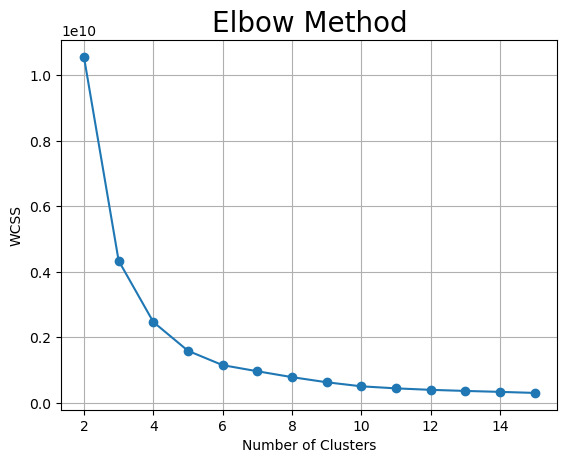

In [39]:
# Menentukan jumlah cluster yang optimal dengan Elbow Method
# Inisialisasi list untuk menyimpan nilai WCSS
wcss = []
random_state = 10
max_cluster = 15
# Menghitung WCSS untuk setiap jumlah cluster dari 2 hingga max_cluster
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(df)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [48]:
# Fungsi untuk membuat Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.3327421313684767
For n_clusters = 3 The average silhouette_score is : 0.2715073872967771
For n_clusters = 4 The average silhouette_score is : 0.23404727741077222
For n_clusters = 5 The average silhouette_score is : 0.22274417765571122
For n_clusters = 6 The average silhouette_score is : 0.2290665341483856
For n_clusters = 7 The average silhouette_score is : 0.24040326466863388
For n_clusters = 8 The average silhouette_score is : 0.23995350655751588
For n_clusters = 9 The average silhouette_score is : 0.2513002229589355
For n_clusters = 10 The average silhouette_score is : 0.2693924740515407
For n_clusters = 11 The average silhouette_score is : 0.2739854267597359
For n_clusters = 12 The average silhouette_score is : 0.2716490564398639
For n_clusters = 13 The average silhouette_score is : 0.28024854539903793
For n_clusters = 14 The average silhouette_score is : 0.28501680834407245


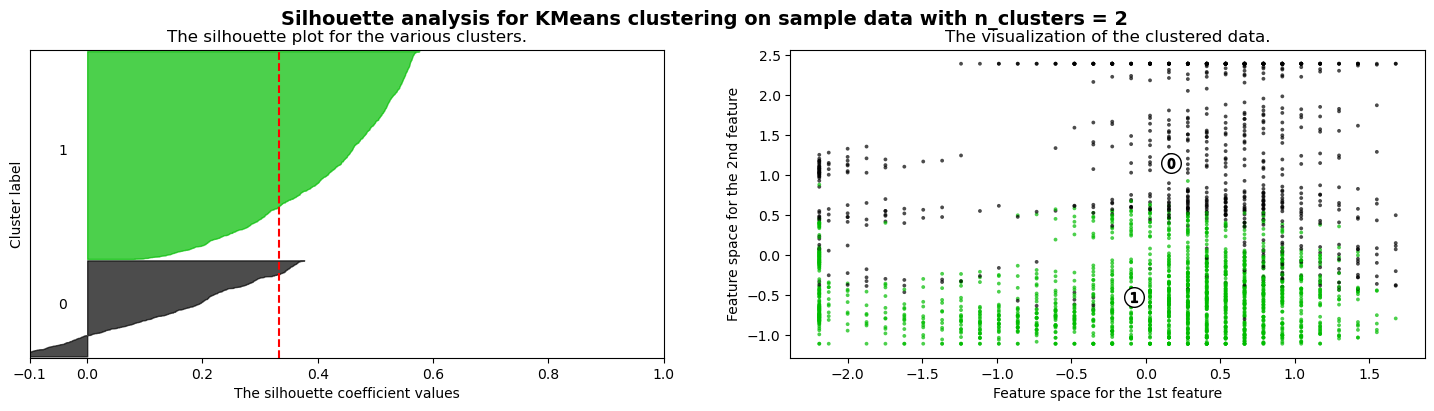

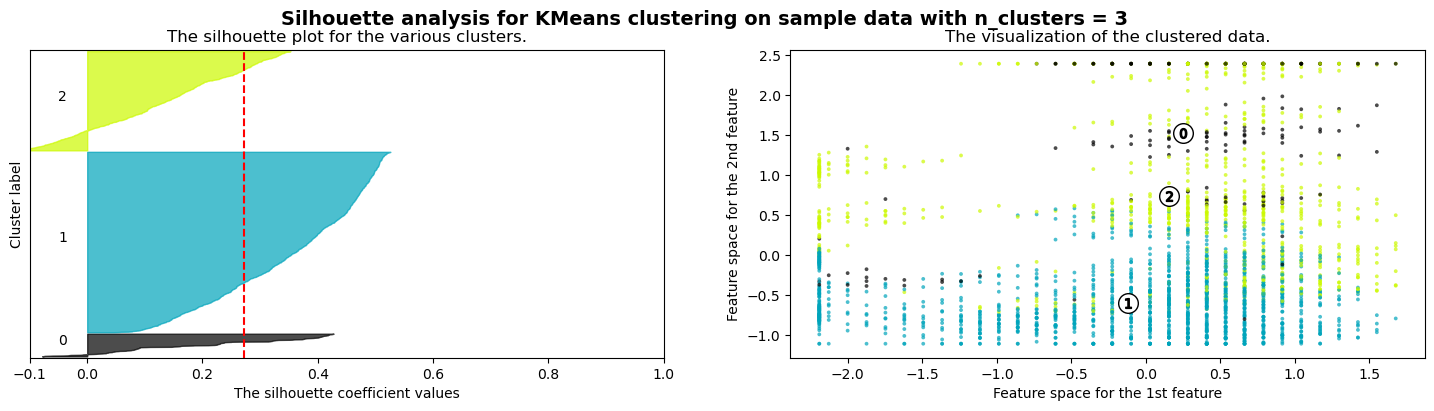

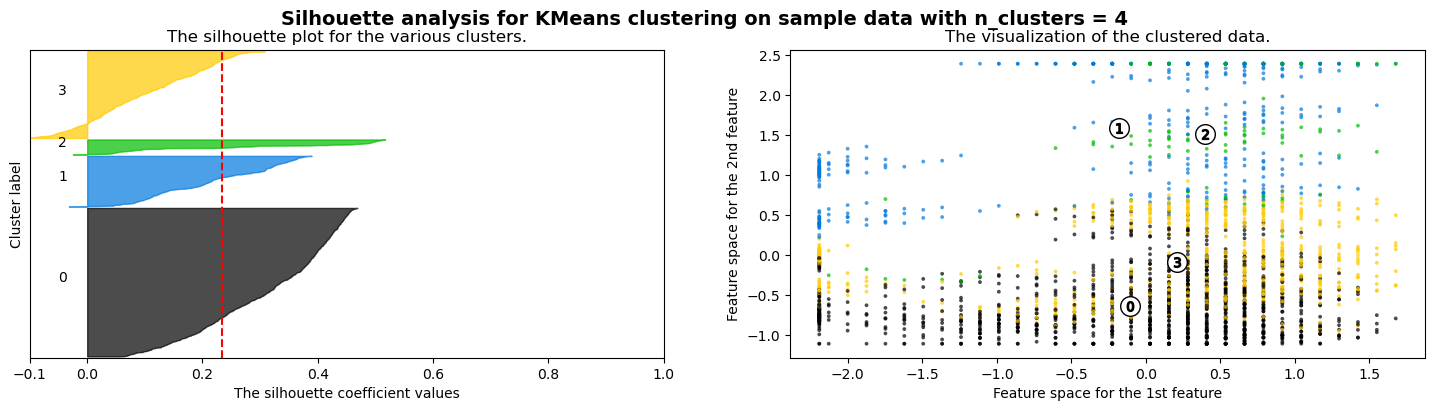

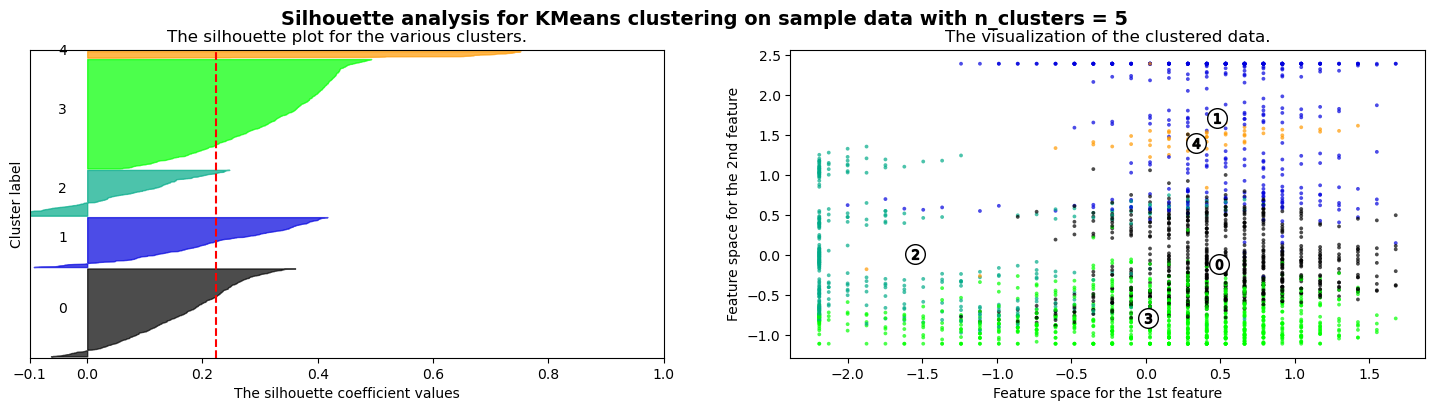

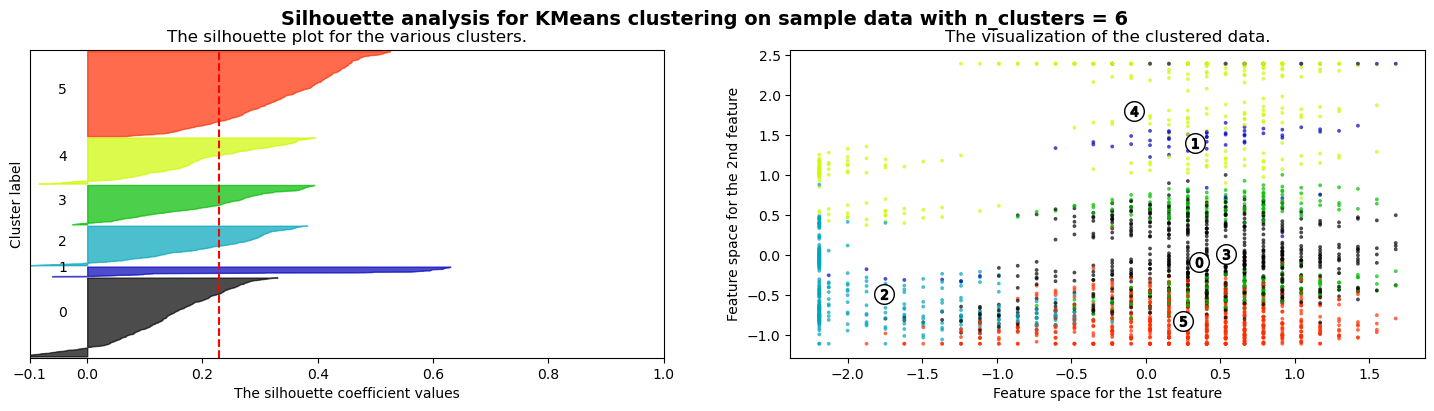

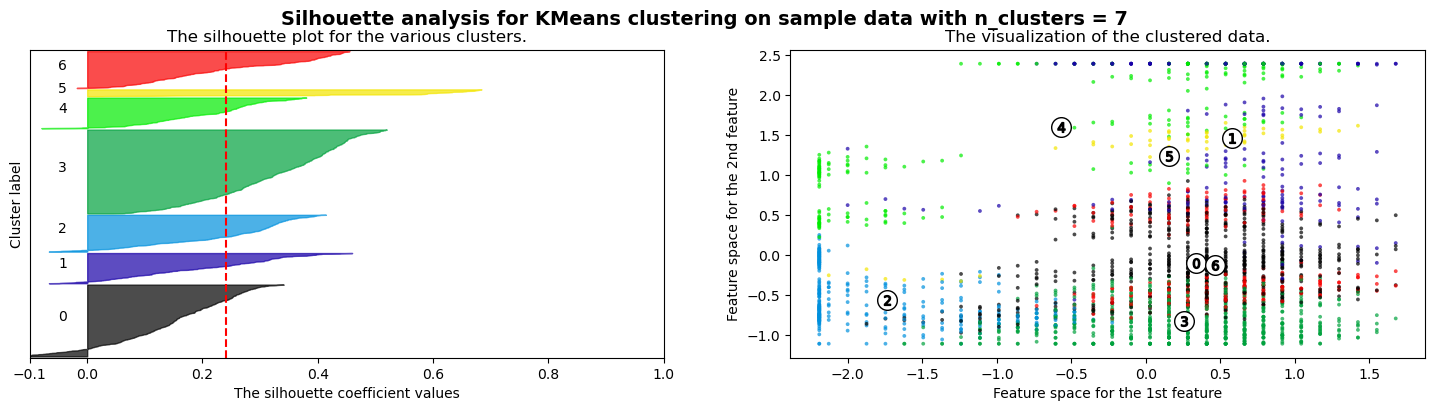

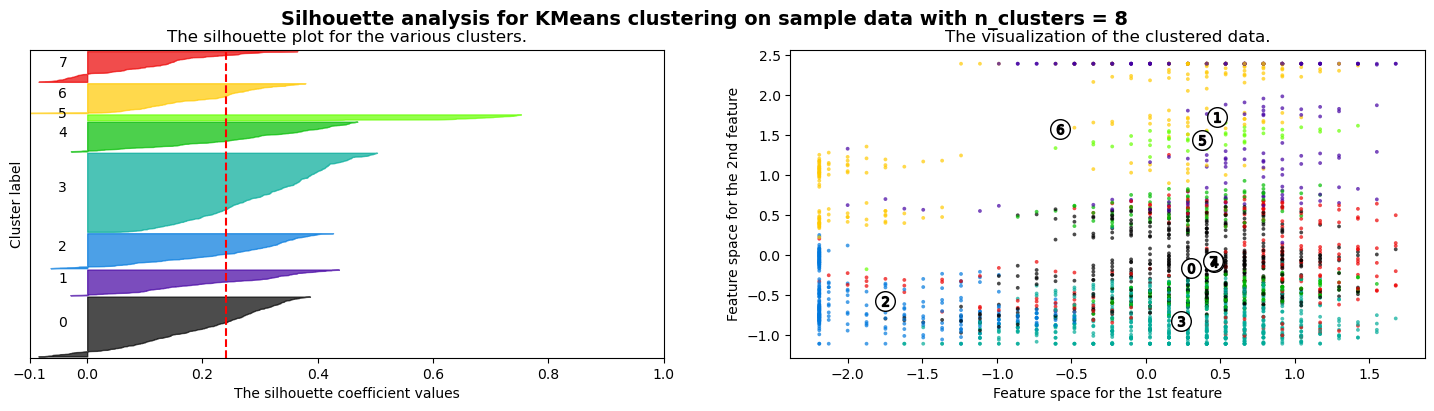

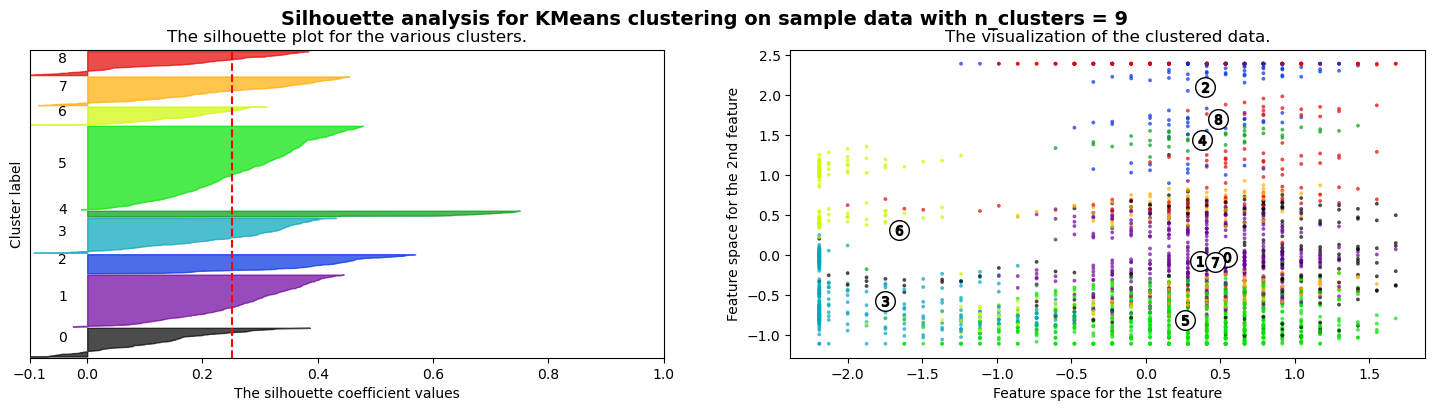

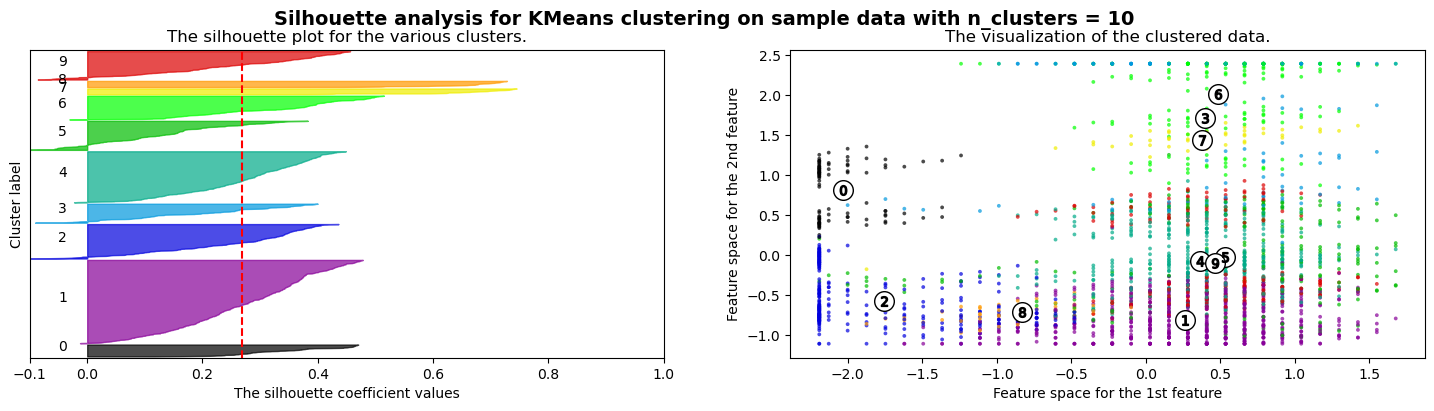

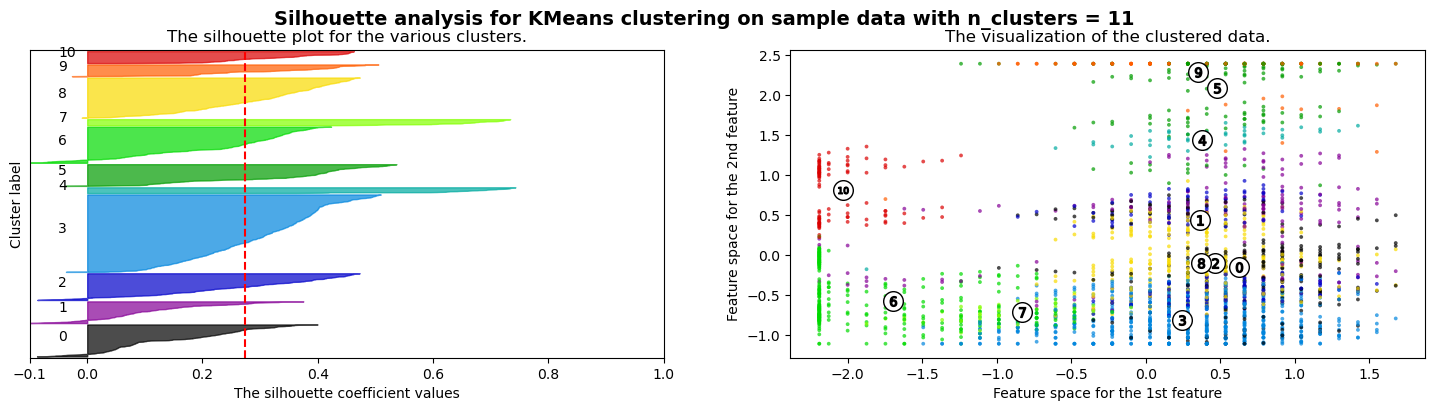

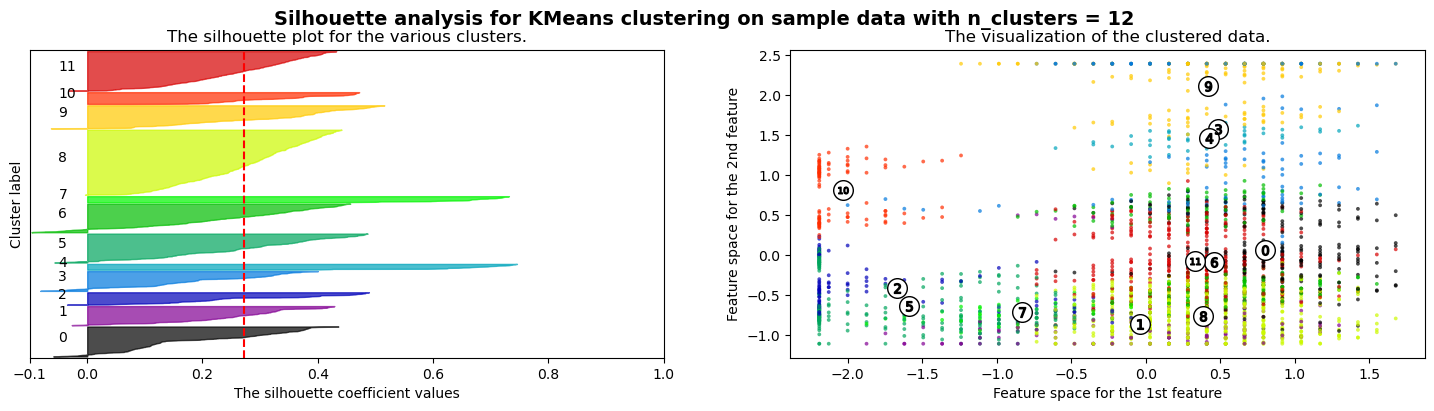

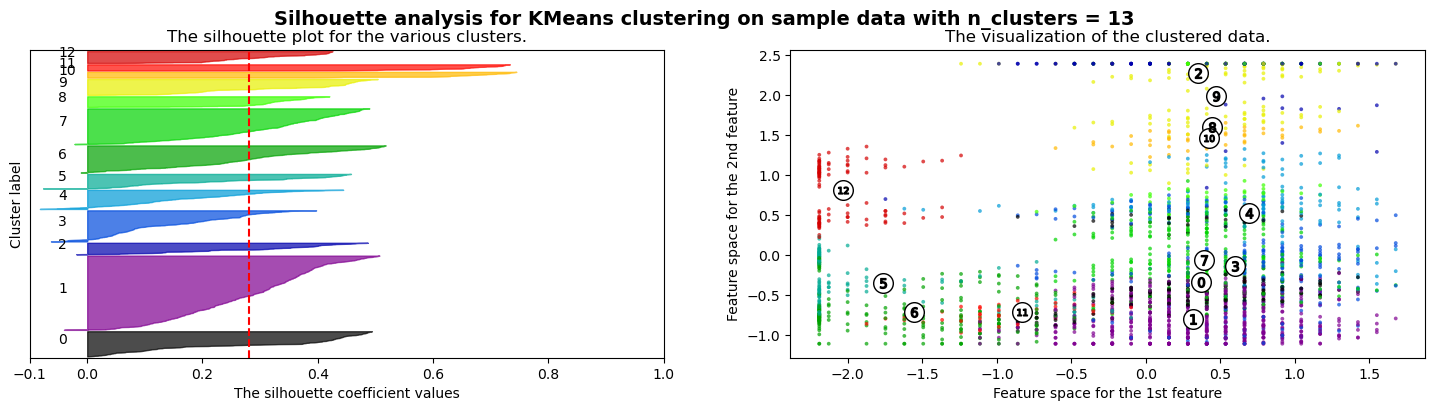

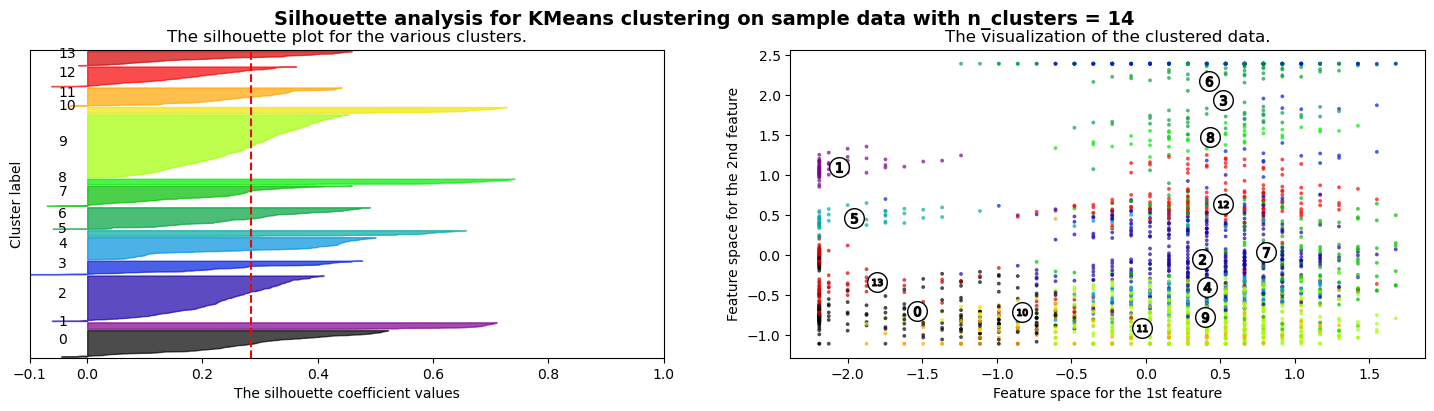

In [49]:
# Menampilkan Silhouette Score and Plot Silhouette Plot
plot_silhouette(range(2, max_cluster), df_preprocessed, random_state)